In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import collections
import gzip
import numpy as np
import os
import phate
import time

import pandas as pd
import pickle as pk

from collections import defaultdict
import itertools

# Interactive HTML tools
from ipywidgets import interact
import bokeh
import bokeh.io
from bokeh.io import push_notebook
from bokeh.plotting import figure, show, save, output_notebook, output_file
from bokeh.palettes import Category20b
from bokeh.palettes import Category20
from bokeh.palettes import Category10
from bokeh.palettes import PRGn
from bokeh.palettes import Set1

# Machine-learning and dimensionality reduction tools
import sklearn
from sklearn import decomposition
from sklearn.decomposition import PCA as PCA # We'll use this to check our implementation
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import MDS

In [118]:
# Import PCA data
data_dir = '/Users/alex/Documents/Ethnicity/HRS_1000G_AJ'
pc_file = 'merged_1000G_HRS_khazar_pca.eigenvec'

pc_path = os.path.join(data_dir, pc_file)

with open(pc_path) as pc:
    pca_contents = pc.readlines()

pca_data = []

for pc in pca_contents:
    pca_data.append(pc.split()[2:len(pc)])

pca_data_array = np.array(pca_data).astype(np.float)

# Import auxiliary data

In [6]:
# Import 1000G auxiliary data
%store -r continents
%store -r pop_by_continent
%store -r pop
%store -r indices_of_population_members
%store -r name_by_code
%store -r continent_by_population
%store -r individuals
%store -r population_by_individual
%store -r individuals_by_population
%store -r populations

# Import HRS auxiliary data
%store -r aux_data_hrs
%store -r hisp_dict
%store -r hisp_dict_rev
%store -r mex_dict
%store -r mex_dict_rev
%store -r race_dict
%store -r race_dict_rev
%store -r brn_dict
%store -r brn_dict_rev
%store -r racedb_dict
%store -r racedb_dict_rev

In [7]:
# Labels for the HRS data aren't as clear - import the code to define those as well.
# These auxiliary data sets will define how we label the observations

# Columns are:
# 0 = ID, 1 = Family ID, 2 = Birth Year
# 3 = Hispanic, 4 = Detailed Hispanic, 5 = Race, 6 = Birth Region, 7 = Birth region name
# 10= dbGaP race (Note: Black != AfrAm and White != Not_AfrAm)

# Create multiple types of categorization based on variables to include
aux_data_1 = [] # 1 - Birth region, race, Hispanic status, Mexican status
aux_data_2 = [] # 2 - Race, Hispanic status, Mexican status
aux_data_3 = [] # 3 - Birth region, race
aux_data_4 = [] # 4 - Race, Hispanic status
aux_data_5 = [] # 5 - Birth region
aux_data_6 = [] # 6 - Birth region, Hispanic status, Mexican status
aux_data_7 = [] # 7 - Birth region, Hispanic status

individuals_hrs = []

aux_data_dict_1 = defaultdict(list)
aux_data_dict_2 = defaultdict(list)
aux_data_dict_3 = defaultdict(list)
aux_data_dict_4 = defaultdict(list)
aux_data_dict_5 = defaultdict(list)
aux_data_dict_6 = defaultdict(list)
aux_data_dict_7 = defaultdict(list)

# Get the lists (skip the first row as it's a header)
for a in aux_data_hrs[1:]:
#for a in aux_data_dict[subset][0:]:
    individuals_hrs.append(a[0])
    
    temp_element = [a[0], '_'.join([brn_dict[a[7]], race_dict[a[5]], hisp_dict[a[3]], mex_dict[a[4]]])]    
    aux_data_1.append(temp_element)
    
    temp_element = [a[0], '_'.join([race_dict[a[5]], hisp_dict[a[3]], mex_dict[a[4]]])]
    aux_data_2.append(temp_element)
    
    temp_element = [a[0], '_'.join([brn_dict[a[7]], race_dict[a[5]]])]
    aux_data_3.append(temp_element)
    
    temp_element = [a[0], '_'.join([race_dict[a[5]], hisp_dict[a[3]]])]
    aux_data_4.append(temp_element)
    
    temp_element = [a[0], '_'.join([brn_dict[a[7]]])]
    aux_data_5.append(temp_element)
    
    temp_element = [a[0], '_'.join([brn_dict[a[7]], hisp_dict[a[3]], mex_dict[a[4]]])]
    aux_data_6.append(temp_element)
    
    temp_element = [a[0], '_'.join([brn_dict[a[7]], hisp_dict[a[3]]])]
    aux_data_7.append(temp_element)

In [23]:
aux_to_use = aux_data_4

In [24]:
# We must define the population dictionary we wish to use
# The following gives us a collection of all categories of some population and/or proxy for ethnicity:
eth_proxy_set = set([a[1] for a in aux_to_use])
pop_dict = dict()

for e in eth_proxy_set:
    el = e.split('_')
    
    if aux_to_use == aux_data_1:    
        temp_brn = brn_dict_rev[el[0]]
        temp_race = race_dict_rev[el[1]]
        temp_hisp = hisp_dict_rev[el[2]]
        temp_mex = mex_dict_rev[el[3]]
        
        pop_dict.update({e:temp_brn + ' ' + temp_race + ' ' + temp_hisp + ' ' + temp_mex})
    elif aux_to_use == aux_data_2:
        temp_race = race_dict_rev[el[0]]
        temp_hisp = hisp_dict_rev[el[1]]
        temp_mex = mex_dict_rev[el[2]]
        temp_list = [temp_race, temp_hisp, temp_mex]
        
        pop_dict.update({e:temp_race + ' ' + temp_hisp + ' ' + temp_mex})
    elif aux_to_use == aux_data_3:
        temp_brn = brn_dict_rev[el[0]]
        temp_race = race_dict_rev[el[1]]
        
        pop_dict.update({e: temp_brn + ' ' + temp_race})
    elif aux_to_use == aux_data_4:
        temp_race = race_dict_rev[el[0]]
        temp_hisp = hisp_dict_rev[el[1]]
        
        pop_dict.update({e: temp_race + ' ' + temp_hisp})
    elif aux_to_use == aux_data_5:
        temp_brn = brn_dict_rev[el[0]]
        
        pop_dict.update({e: temp_brn})
    elif aux_to_use == aux_data_6:
        temp_brn = brn_dict_rev[el[0]]
        temp_hisp = hisp_dict_rev[el[1]]
        temp_mex = mex_dict_rev[el[2]]
        
        pop_dict.update({e: temp_brn + ' ' + temp_hisp + ' ' + temp_mex})
    elif aux_to_use == aux_data_7:
        temp_brn = brn_dict_rev[el[0]]
        temp_hisp = hisp_dict_rev[el[1]]
        
        pop_dict.update({e: temp_brn + ' ' + temp_hisp})

In [25]:
# Set up an index of each population member and vice versa
# We want to quickly access a given individual's population and a given population's individuals
population_by_individual_hrs = defaultdict(int)
individuals_by_population_hrs = defaultdict(list)

for a in aux_to_use:
    population_by_individual_hrs[a[0]] = a[1]
    individuals_by_population_hrs[a[1]].append(a[0])
    
indices_of_population_members_hrs = defaultdict(list)

for index, indiv in enumerate(individuals_hrs):
    try:
        indices_of_population_members_hrs[population_by_individual_hrs[indiv]].append(index)
    except KeyError:
        continue

In [66]:
# Colour dictionaries
# Need to define colour dictionaries - just go with what was previously set up
color_dict_1000g = {}
for i, cont in enumerate(continents): 
    for j, pop in enumerate(pop_by_continent[cont]):
        color_dict_1000g[pop] = Category20b[20][4*i+j%4]
        
color_dict_hrs = {}

for j, pop in enumerate(eth_proxy_set):
    if j < 20:
        color_dict_hrs[pop] = Category20[20][j]
    elif j < 30:
        color_dict_hrs[pop] = PRGn[10][j%20]
    else:
        color_dict_hrs[pop] = Set1[9][j%30]

In [90]:
# Get some Jewish auxiliary data (quick 'n dirty for now)
# Note that for this dataset we only merged the "new data" for hte Khazar paper (minor oversight but still works)
data_dir_jewish = '/Users/alex/Documents/Ethnicity/jewish_genotype/full_data_panel_for_khazar_paper'

with open(os.path.join(data_dir_jewish,'khazar3_1-22_maf0.01mind0.035geno0.005.fam')) as line:
    aux_data_jewish_new = line.readlines()

for j in range(0,len(aux_data_jewish_new)):
    aux_data_jewish_new[j] = aux_data_jewish_new[j].strip().split()[0:2]
    
#aux_data_jewish_new = 

In [92]:
len(aux_data_jewish_new)

1774

In [121]:
# Get the number of people in each group - the dataset is stacked such that we have HRS, 1000G, and the Jewish set
# Note: PLINK removed 23 individuals as duplicates
n_hrs = len(aux_data_hrs)-1
n_1000g = len(individuals)
n_jewish = tsne_proj.shape[0] - n_hrs - n_1000g

In [126]:
# Generate t-SNE projection
tsne_dir = os.path.join(data_dir, 'TSNE_projections_khazar')

pc_list = [10]

for pc in pc_list:
    tsne_proj = TSNE(n_components=2).fit_transform(pca_data_array[:n_hrs+n_1000g,:pc])
    #filename = 'TSNE_HRS_1000G_AJ_PC'+str(pc)+'_PLEX30'
    #np.savetxt(os.path.join(tsne_dir,filename), tsne_proj)

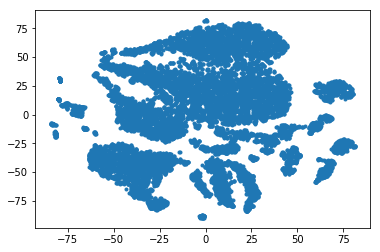

In [127]:
plt.plot(tsne_proj[:,0], tsne_proj[:,1], '.')

In [128]:
proj_data = np.loadtxt('/Users/alex/Documents/Ethnicity/HRS_1000G_AJ/TSNE_projections_khazar/TSNE_HRS_1000G_AJ_PC10_PLEX30')

# Separate the three datasets
proj_data_hrs = proj_data[0:n_hrs,:]
proj_data_1000g = proj_data[n_hrs:n_hrs+n_1000g,:]
proj_data_jewish = proj_data[n_hrs+n_1000g:,:]

p = figure(plot_width=1500, plot_height=1200)
p.title.text = 'ptitle'

# First loop is for HRS data
for pop in sorted(eth_proxy_set):
    proj_pop = proj_data_hrs[indices_of_population_members_hrs[pop]]
    p.circle(proj_pop[:,0], proj_pop[:,1], legend=pop_dict[pop],color=color_dict_hrs[pop])

# Second loop is for 1000G data
for cont in continents: 
    for pop in pop_by_continent[cont]:
        proj_pop = proj_data_1000g[indices_of_population_members[pop]]
        p.circle(proj_pop[:,0], proj_pop[:,1], legend=name_by_code[pop], color=color_dict_1000g[pop])

# Third loop is the remaining observations
#proj_pop = proj_data_jewish
#p.circle(proj_pop[:,0], proj_pop[:,1],legend='Jewish')

p.legend.location = "top_left"

p.legend.click_policy="hide"

output_file('test.html',title='test')

save(p)

'/Users/alex/Documents/Ethnicity/test.html'

# Reference

#!/bin/bash

#PBS -q sw
#PBS -l nodes=1:ppn=4

#PBS -l walltime=2:00:00
#PBS -N pipeline_merge_HRS1000G_khazar_pca

cd /home/adiazpop/Ethnicity/HRS/data

plink --bfile khazar3_1-22_maf0.01mind0.035geno0.005 --maf 0.05 --mind 0.1 --geno 0.1 --hwe 1e-6 --make-bed --out khazar

sort khazar.bim > khazar_sorted.bim
sort merged_1000G_HRS.bim > merged_1000G_HRS_sorted.bim

comm -12 merged_1000G_HRS_sorted.bim khazar_sorted.bim > common_snps_HRS_1000G_khazar.txt

plink --bfile merged_1000G_HRS --extract common_snps_HRS_1000G_khazar.txt --make-bed --out merged_1000G_HRS_khazar_common
plink --bfile khazar --extract common_snps_HRS_1000G_khazar.txt --make-bed --out khazar_common
plink --bfile merged_1000G_HRS_khazar_common --bmerge khazar_common --make-bed --out merged_1000G_HRS_khazar

plink --bfile merged_1000G_HRS_khazar --pca 50 --out merged_1000G_HRS_khazar_pca

exit